In [27]:
print("Importing Library...")
import torch
import torchvision

from torch import nn, optim
from torchvision import datasets,transforms
from torch.autograd import Variable
from PIL import Image
import numpy
import numpy as np
print("Importing Library Success")

Importing Library...
Importing Library Success


In [31]:
print("Defining Class...")
class ComCNN(nn.Module):
    def __init__(self,channel):
        super(ComCNN,self).__init__()
        self.conv1 = nn.Conv2d(channel,out_channels=64,kernel_size=3,stride=1,padding=1)
        self.conv2 = nn.Conv2d(64,64,kernel_size=3,stride=2,padding=0)
        self.bn1 = nn.BatchNorm2d(64,affine=False)
        self.conv3 = nn.Conv2d(64, channel, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
    
    def forward(self,x):
        out = self.relu(self.conv1(x))
        out = self.relu(self.bn1(self.conv2(out)))
        return self.conv3(out)
    
class RecCNN(nn.Module):
    def __init__(self,channel):
        super(RecCNN,self).__init__()
        self.deconv1 = nn.Conv2d(channel,out_channels=64,kernel_size=3,stride=1,padding=1)
        self.bn2 = nn.BatchNorm2d(64,affine=False)
        self.deconv_n = nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding=1)
        self.bn_n = nn.BatchNorm2d(64,affine=False)
        self.deconv3 = nn.ConvTranspose2d(64,channel,kernel_size=3,stride=1,padding=1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        out = self.relu(self.deconv1(x))
        for _ in range(18):
            out = self.relu(self.bn_n(self.deconv_n(out)))
        out = self.deconv3(out)
        final = out + x
        return final,out,x


class CODEC():
    def __init__(self,size,interpolate_size,mode):
        self.size = size
        self.interpolate_size = interpolate_size
        self.mode = mode
    
    def btc(self,image):
        # TODO: Reshape block_image to bethe same as image shape
        x = image.shape[0]/self.size
        y = image.shape[1]/self.size
        block_image = numpy.split(numpy.concatenate(numpy.split(image,y,axis=1)),x*y)
        for i in range(len(block_image)):
            mean = numpy.mean(np.mean(block_image[i],axis=1))
            std = numpy.std(block_image[i])
            m =  self.size*self.size
            q = numpy.sum(block_image[i] > mean)
            
            a = mean - std*numpy.sqrt(q/(m-q))
            b = mean + std*numpy.sqrt((m-q)/q)
            
            
            block_image[i][block_image[i]>mean] = b
            block_image[i][block_image[i]<mean] = a
            
        return block_image
    
    def interpolate(image):
        return nn.functional.interpolate(image,size=self.size,mode=self.mode)

def loss_function_l1(reconstructed_image,original_image):
    return nn.MSELoss(size_average=False)(original_image,reconstructed_image)

def loss_function_l2(residual_image,decoded_image,original_image):
    return nn.MSELoss(size_average=False)(residual_image-decoded_image,original_image)


print("Defining Class Success")

Defining Class...
Defining Class Success


In [3]:
print("Load Image Dataset")
image_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

train_set = datasets.CIFAR10(root='./data',train=True,download=True,transform=image_transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32,
                                          shuffle=True, num_workers=2)

test_set = datasets.CIFAR10(root='./data',train=False,download=True,transform=image_transform)

test_loader = torch.utils.data.DataLoader(test_set,batch_size=32,
                                          shuffle=True,num_workers=2)
print("Load Image Dataset Success")

Load Image Dataset
Files already downloaded and verified
Files already downloaded and verified
Load Image Dataset Success


In [25]:
print("Initialize Model....")
CUDA = torch.cuda.is_available()

codec = CODEC(4,2,'bicubic')

if CUDA:
    comCNN = ComCNN(1).cuda()
    recCNN = RecCNN(1).cuda()
    print("Cuda is available, using gpu instead")
else:
    comCNN = ComCNN(1)
    recCNN = RecCNN(1)
    print("Cuda is not available, using cpu instead")

comCNNOptimizer = optim.Adam(comCNN.parameters(),lr=1e-3)

recCNNOptimizer = optim.Adam(recCNN.parameters(),lr=1e-3)

print("Initialize Model Success")


Initialize Model....
Cuda is available, using gpu instead
Initialize Model Success


In [5]:
print("testing")
comCNN.train()
recCNN.train()
for batch_idx, (data,_) in enumerate (train_loader):
    data = Variable(data)
    comCNNOptimizer.zero_grad()
    recCNNOptimizer.zero_grad()
    
    compact_image = comCNN(data.cuda())
    break;

print("end")


testing
end


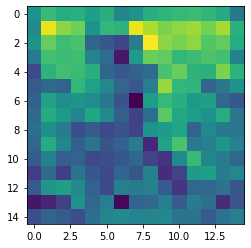

In [18]:
import matplotlib.pyplot as plt
a = compact_image.cpu()
a = a.detach()
plt.imshow(a[0][0])

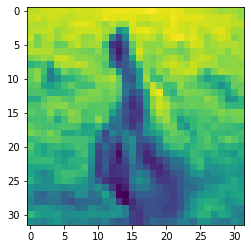

In [22]:
plt.imshow(data[0][0])

In [29]:
compressed = codec.btc(data[0][0])
c = np.concatenate(compressed)
b = np.split(c,15/4)
d = np.concatenate(b,axis=1)
print(d)
print(d.shape)

ValueError: array split does not result in an equal division